## School Versus Enrollment Area Demographics

A descriptive analysis of the differences between the demographics of schools versus the schools' enrollment areas, for schools in the San Diego Unified district. 


Since [at least the early 1980's](https://www.csmonitor.com/1981/0330/033025.html), San Diego unified has pursued a voluntary busing policy for desegregating neighborhood schools. The core of that policy is Magnet Schools, high-quality schools oriented around specific topics or educational goals, which were preferentially situated in lower-income and minority neighborhoods. Along with a generous city-wide busing program, the magnet schools would encourage higher-income families to voluntarily send their children to schools in lower income areas. The District also made it easier for lower-income parents to send their children to schools in higher-income neighborhoods. 

The result of these policies should be a general disparity between the demographics of school enrollment areas and the schools in the areas. This analysis demonstrates several of the datasets in the [Data Library's education collection](https://data.sandiegodata.org/collections/california-department-of-education/) with maps of the demographics of San Diego Unified schools and the school enrollment zones. 

The main datasets we'll be using are: 

* [San Diego Unified School Enrollment Boundaries](https://data.sandiegodata.org/dataset/sandiegounified-org-enrollment-zones-2014/). Geographic boundaries for schools in the San Diego Unified school district
* [Enrollment by School](https://data.sandiegodata.org/dataset/cde-ca-gov-enrollment/). School-level enrollment by racial/ethnic designation, gender, and grade for California schools
* [San Diego Planning Database](https://data.sandiegodata.org/dataset/sandiegodata-org-planning/). A selection of Census and ACS demographics for San Diego county tracts. 

An important component of the analysis to a school enrollment zone to tract crosswalk in the [San Diego Unified School Enrollment Boundaries](https://data.sandiegodata.org/dataset/sandiegounified-org-enrollment-zones-2014/) dataset. This crosswalk has, for each tract in San Diego, the portion of the tract that is in each school enrollment zone that the tract overlaps. These proportions can be multiplied by demographic counts and summed to generate census statistics for the school enrollment zone. 

( Caveat: we'll be using demographic values from the American Community Survey, which have a sampling error. We're ignoring that error, because it is hard to include in vizualizations, but if we were doing ranking or numerical comparisons, it would be important to include these errors. ) 

If you'd like to see how the whole process works, see the [Jupyter notebook available at the link above](https://github.com/CivicKnowledge/insights.civicknowledge.com/blob/master/education/SchoolVsEnrollmentDemo.ipynb). 


In [12]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from rowgenerators import dataframe, geoframe
import contextily as ctx

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

#import warnings
#warnings.filterwarnings('ignore')


In [13]:
##
## Open the packages we'll need
##

# Geo boundaries of enrollment zones, for San Diego Unified schools
pkg = mp.open_package('http://library.metatab.org/sandiegounified.org-enrollment_zones-2014-1.zip')
xwalk = pkg.resource('school_tract_xwalk').dataframe()
bound = pkg.resource('sdusd_boundaries').geoframe()

# Enrollment and race stats for all CA schools
enrol_pkg = mp.open_package('http://library.metatab.org/cde.ca.gov-enrollment-1.zip')
raceeth = enrol_pkg.resource('race_eth_07_18').dataframe()

# San Diego PLanning database, a cheap source for Census and ACS demographics
pdb_pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-planning-1.csv') 
pdb = pdb_pkg.resource('acs_pdb').dataframe(dtype=False) 



In [3]:
##
## Assemble race/eth demographics for hispanics, asiand and whites, 
## for the enrollment zone

dem_cols = ['pop_5_17','nh_white_alone','nh_asian_alone', 'hispanic' ]

dem_cols_t = dem_cols  + ['tot_population']

t = xwalk.merge(pdb[['geoid'] + dem_cols_t], on='geoid')

for c in dem_cols_t:
    t[c] = t[c] * t.tract_in_school

    
t.rename(columns={
    'nh_white_alone':'zone_white',
    'nh_asian_alone':'zone_asian',
    'hispanic':'zone_hisp',
    'tot_population':'zone_population'
}, inplace=True)
    
tc = t.groupby('cdscode').sum().reset_index()

# Calc percentages
for c in tc.columns:
    if 'zone_' in c and 'population' not in c:
        tc[c] = tc[c] / tc.zone_population
    
tc = tc[  ['cdscode'] + [c for c in tc.columns if 'zone_' in c] ]


In [4]:
##
## Assemble the race/eth stats for the schools

raceeth = raceeth[raceeth.year == 2016] # Maybe the same year as the census data
raceeth.rename(columns={
    'total':'school_population',
    'hisp':'school_hisp',
    'asian':'school_asian',
    'nh_white':'school_white'    
}, inplace=True)
raceeth = raceeth[['cdscode','school_white','school_asian','school_hisp','school_population']]

for c in raceeth.columns:
    if 'school_' in c and 'population' not in c:
        raceeth[c] = raceeth[c] / raceeth.school_population

raceeth = raceeth[  ['cdscode'] + [c for c in raceeth.columns if 'school_' in c] ]


In [5]:
##
## Merge into one dataframe

df = bound[['cdscode','school','group','geometry']].merge(tc, on='cdscode').merge(raceeth, on='cdscode')


In [6]:
# Create a subset for platting ( select one of Elementary, Middle or High schools)
# And change the CRS to match the basemaps. 

plt_df = df[df.group=='MID'].to_crs(epsg=3857)

In [7]:
# From the Geopandas docs, a helper for adding a basemap
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [8]:
# Function for our particular visualization

def plot_maps(df, raceeth):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,10))

    for ax  in (ax1, ax2, ax3):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    f.suptitle(f'Demographics of Schools and Scholl Enrollment Zones\nPercentage {raceeth.title()}', fontsize=18);

    # Map 1
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    ax1.set_title('For Residents in School Enrollment Zone')
    df.plot(column=f'zone_{raceeth}', ax=ax1, cax=cax1,legend=True, alpha=0.9)

    add_basemap(ax1, zoom=12, url=ctx.sources.ST_TONER_LITE)

    # Map 2
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.1)
    ax2.set_title('For School')
    df.plot(column=f'school_{raceeth}', ax=ax2, cax=cax2, legend=True, alpha=0.9)

    add_basemap(ax2, zoom=12, url=ctx.sources.ST_TONER_LITE)

    # Map 3
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.1)
    ax3.set_title('Difference in Percentage Points\n')
    t = df.copy()
    t['raceeth_diff'] = (t[f'school_{raceeth}']-t[f'zone_{raceeth}']) #/ ((t.zone_white+t.school_white)/2)

    t.plot(column='raceeth_diff', legend=True, cmap='plasma', cax=cax3, ax=ax3, alpha=.9)

    add_basemap(ax3, zoom=12, url=ctx.sources.ST_TONER_LITE)

    f.tight_layout()

# Results

The results of the analysis are shown in groups of three maps, one set for each race/ethnicity of non-hispanic white, non-hispanic asian, and hispanics. The first map in each group is the portion ( from 0 to 1 ) of the total population of the given race/ethnicity. The second is that portion of the school population for that race/ethnicity. The third map is of the absolute difference between the values of the first two maps. 

More caveats:
* The populations in the first maps are for the total population in the enrollment zone, not the population of school-aged children. 
* Each of the three maps map have a different scale. The values associated with a color in the first two maps will be close, but not the same. 



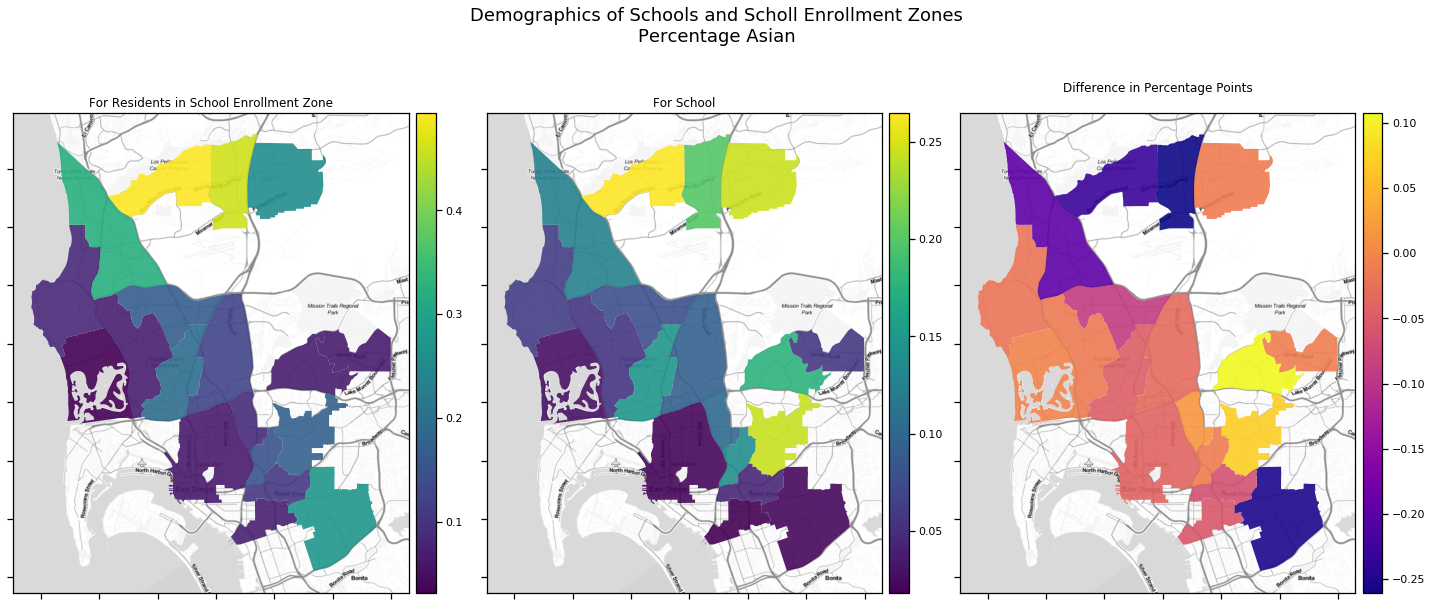

In [9]:
# Now we can do our plots. 
plot_maps(plt_df, 'asian')

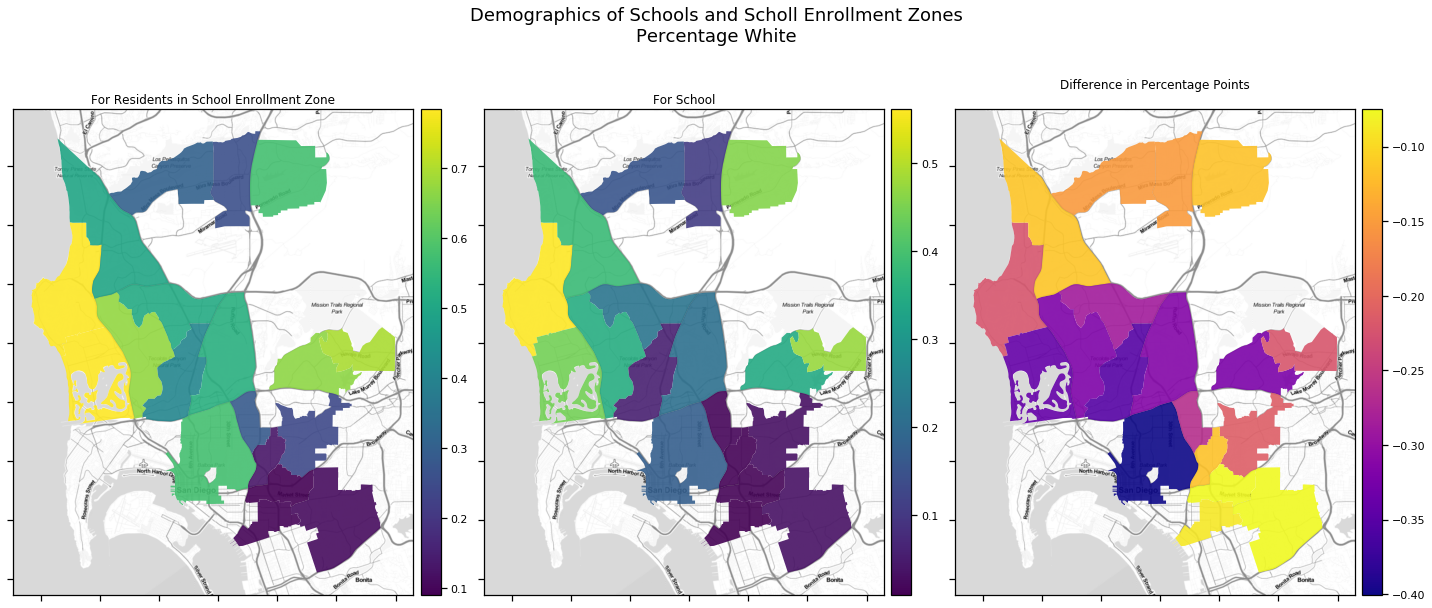

In [10]:
plot_maps(plt_df, 'white')

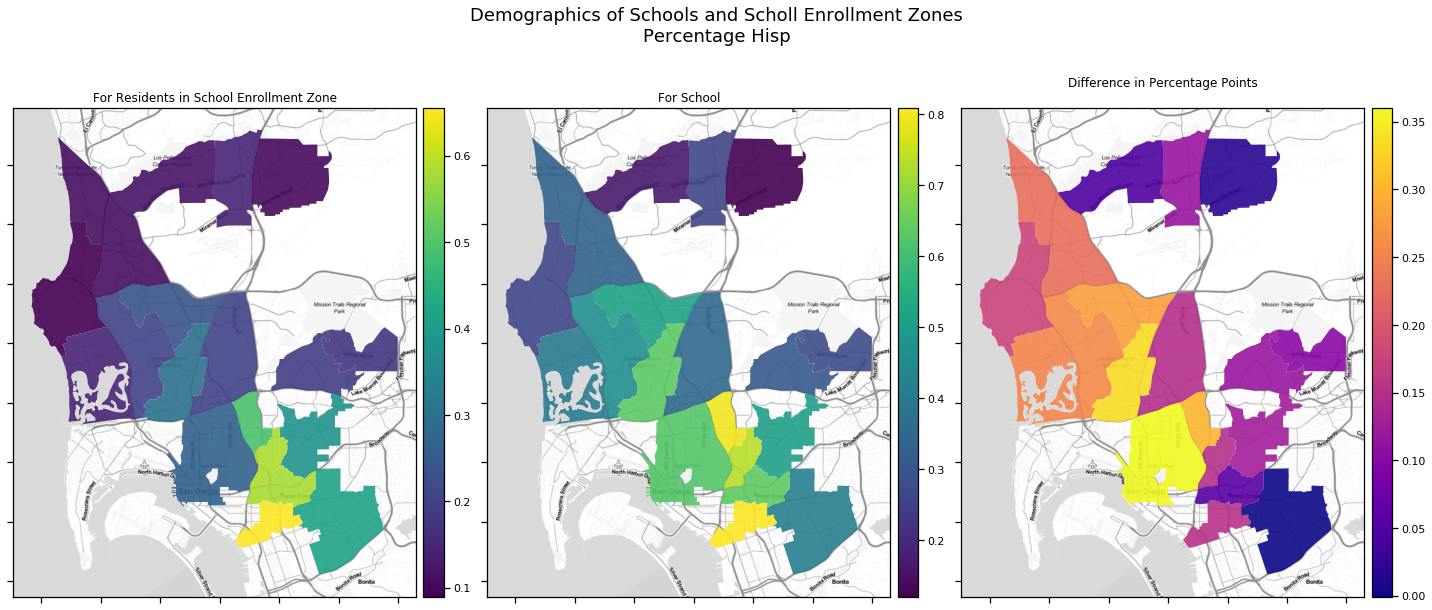

In [11]:
plot_maps(plt_df, 'hisp')